In [1]:
#!/usr/bin/env python
"""
Demo for STEMPO dynamic tomography test problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Silvia Gazzola"
__affiliations__ = 'MIT and Tufts University, and University of Bath'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "Apache"
__version__ = "1.0"
__email__ = "mpasha@mit.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk;"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
import time
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import astra
from venv import create
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.solvers.MMGKS import *
import requests
import numpy as np
import h5py
import pylops
from trips.utilities.helpers import *
from trips.utilities.io import *
from trips.utilities.operators import *
from trips.solvers.Hybrid_LSQR import *

c:\Users\okuno\Downloads\Dynamic_Inverse_Problesm_with_Optical_Flow\Dynamic_Inverse_Problesm_with_Optical_Flow\trips\utilities\io.py:127: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
  if ('noise_level' in kwargs) and noise_level is not 0:


# Notebook 1: STEMPO test problem

<p>In this example we illustrate the following:
<p>&nbsp; Step 1: Download/read the STEMPO data and prepare them for processing.
<p>&nbsp; Step 2: Solve the static inverse problem.
<p>&nbsp; Step 3: Solve the dynamic inverse problem.

CrossPhantom data are generated at the University of Helsinki: https://zenodo.org/record/7147139

#### Step 1: Download/read the data and prepare them for processing
##### <span style='background :blue' >  Note: The following function should automatically download the data and place them in the right folder in TRIPs-Py. Nevertheless, if the following functionality fails to obtain the data, the user can manually download the respective dataset from https://zenodo.org/record/7147139 and place them on a folder named data inside the directory demos. </span>
 
##### The main function to generate the emoji data is generate_crossPhantom(dataset, noise_level) 
<p> <b>Input:</b> 
<p>&nbsp; <b>dataset:</b>
        <p>&nbsp; if dataset = 15, we generate data from DataDynamic_128x15.mat
        <p>&nbsp; if dataset = 60, we generate data from DataDynamic_128x60.mat
<p>&nbsp; <b>noise_level:</b>
        <p>&nbsp; CrossPhantom data are real data and they have noise. Hence, we set noise_level = 0
            
<p> <b>Output:</b>  
&nbsp;<br> <b>A:</b> The full forward operator for all time instances<br>
&nbsp; <b>b:</b> All the data/measurements vectorized<br> 
&nbsp; <b>AA:</b> A list of 16 time-wise operators<br> 
&nbsp; <b>B:</b> A list of 16 data vectors for each time instance <br> 
&nbsp; <b>nx:</b> The dimension of the first spatial domain<br> 
&nbsp; <b>ny:</b> The dimension of the second spatial domain<br> 
&nbsp; <b>nt:</b> The dimension of the time instances domain<br> 
&nbsp; <b>delta:</b> The noise level in the data. When we set noise_level == 0, we get delta = 0<br> 
&nbsp; <b>sinoshape:</b> The dimension of the time-wise sinogram<br>     

## With old "generate_stempo" function

In [3]:
(F, d, Aseq, B, nx, ny, nt, savedelta, truth) = generate_stempo1_old(data_set = 'simulation', data_thinning = 2,  views=11, new_shape= (50,50),columnsshift=14,noise_level = 0.01)

In [5]:
data_file = {'simulation':'stempo_ground_truth_2d_b4','real':'stempo_seq8x45_2d_b'+str(2)}['simulation']+'.mat'
if not os.path.exists('./data/stempo_data'): print('u')
if not os.path.exists('./data/stempo_data/'+data_file): print('y')

#### Access all the ground truth images (360 images of size 560 x 560)

In [6]:
f = spio.loadmat(f'./data/stempo_data/stempo_ground_truth_2d_b4.mat')

(-0.5, 559.5, 559.5, -0.5)

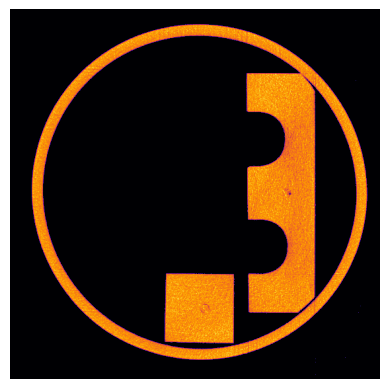

In [7]:
plt.imshow(f['obj'][:,:, 2], cmap = 'inferno')
plt.axis('off')

#### Step 2: Solve the static inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [20]:
timestep = 9
L = spatial_derivative_operator(nx, ny, 1)
b_vec = B[timestep].reshape((-1,1))
(x, info) = MMGKS(Aseq[timestep], b_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter = 10, regparam = 'gcv', x_true=None)


running MMGKS...: 100%|██████████| 10/10 [00:00<00:00, 23.55it/s]


(-0.5, 49.5, 49.5, -0.5)

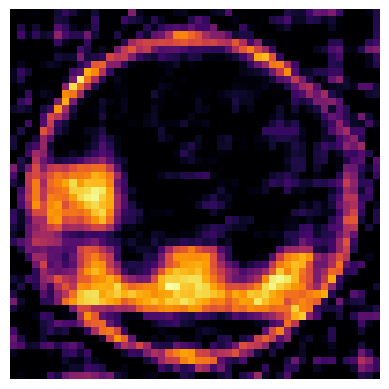

In [21]:
x[x<0] = 0
plt.imshow(x.reshape((nx, ny)))
plt.set_cmap('inferno')
plt.axis('off')

In [18]:
xx = list(range(nt))
L = spatial_derivative_operator(nx, ny, 1)
for i in range(nt):
    b_vec = B[i].reshape((-1,1))
    (x, info) = MMGKS(Aseq[i], b_vec, L, pnorm=2, qnorm=1, projection_dim=3, n_iter = 10, regparam = 'gcv', x_true=None)
    xx[i] = x

running MMGKS...: 100%|██████████| 10/10 [00:00<00:00, 22.13it/s]


<Figure size 640x480 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

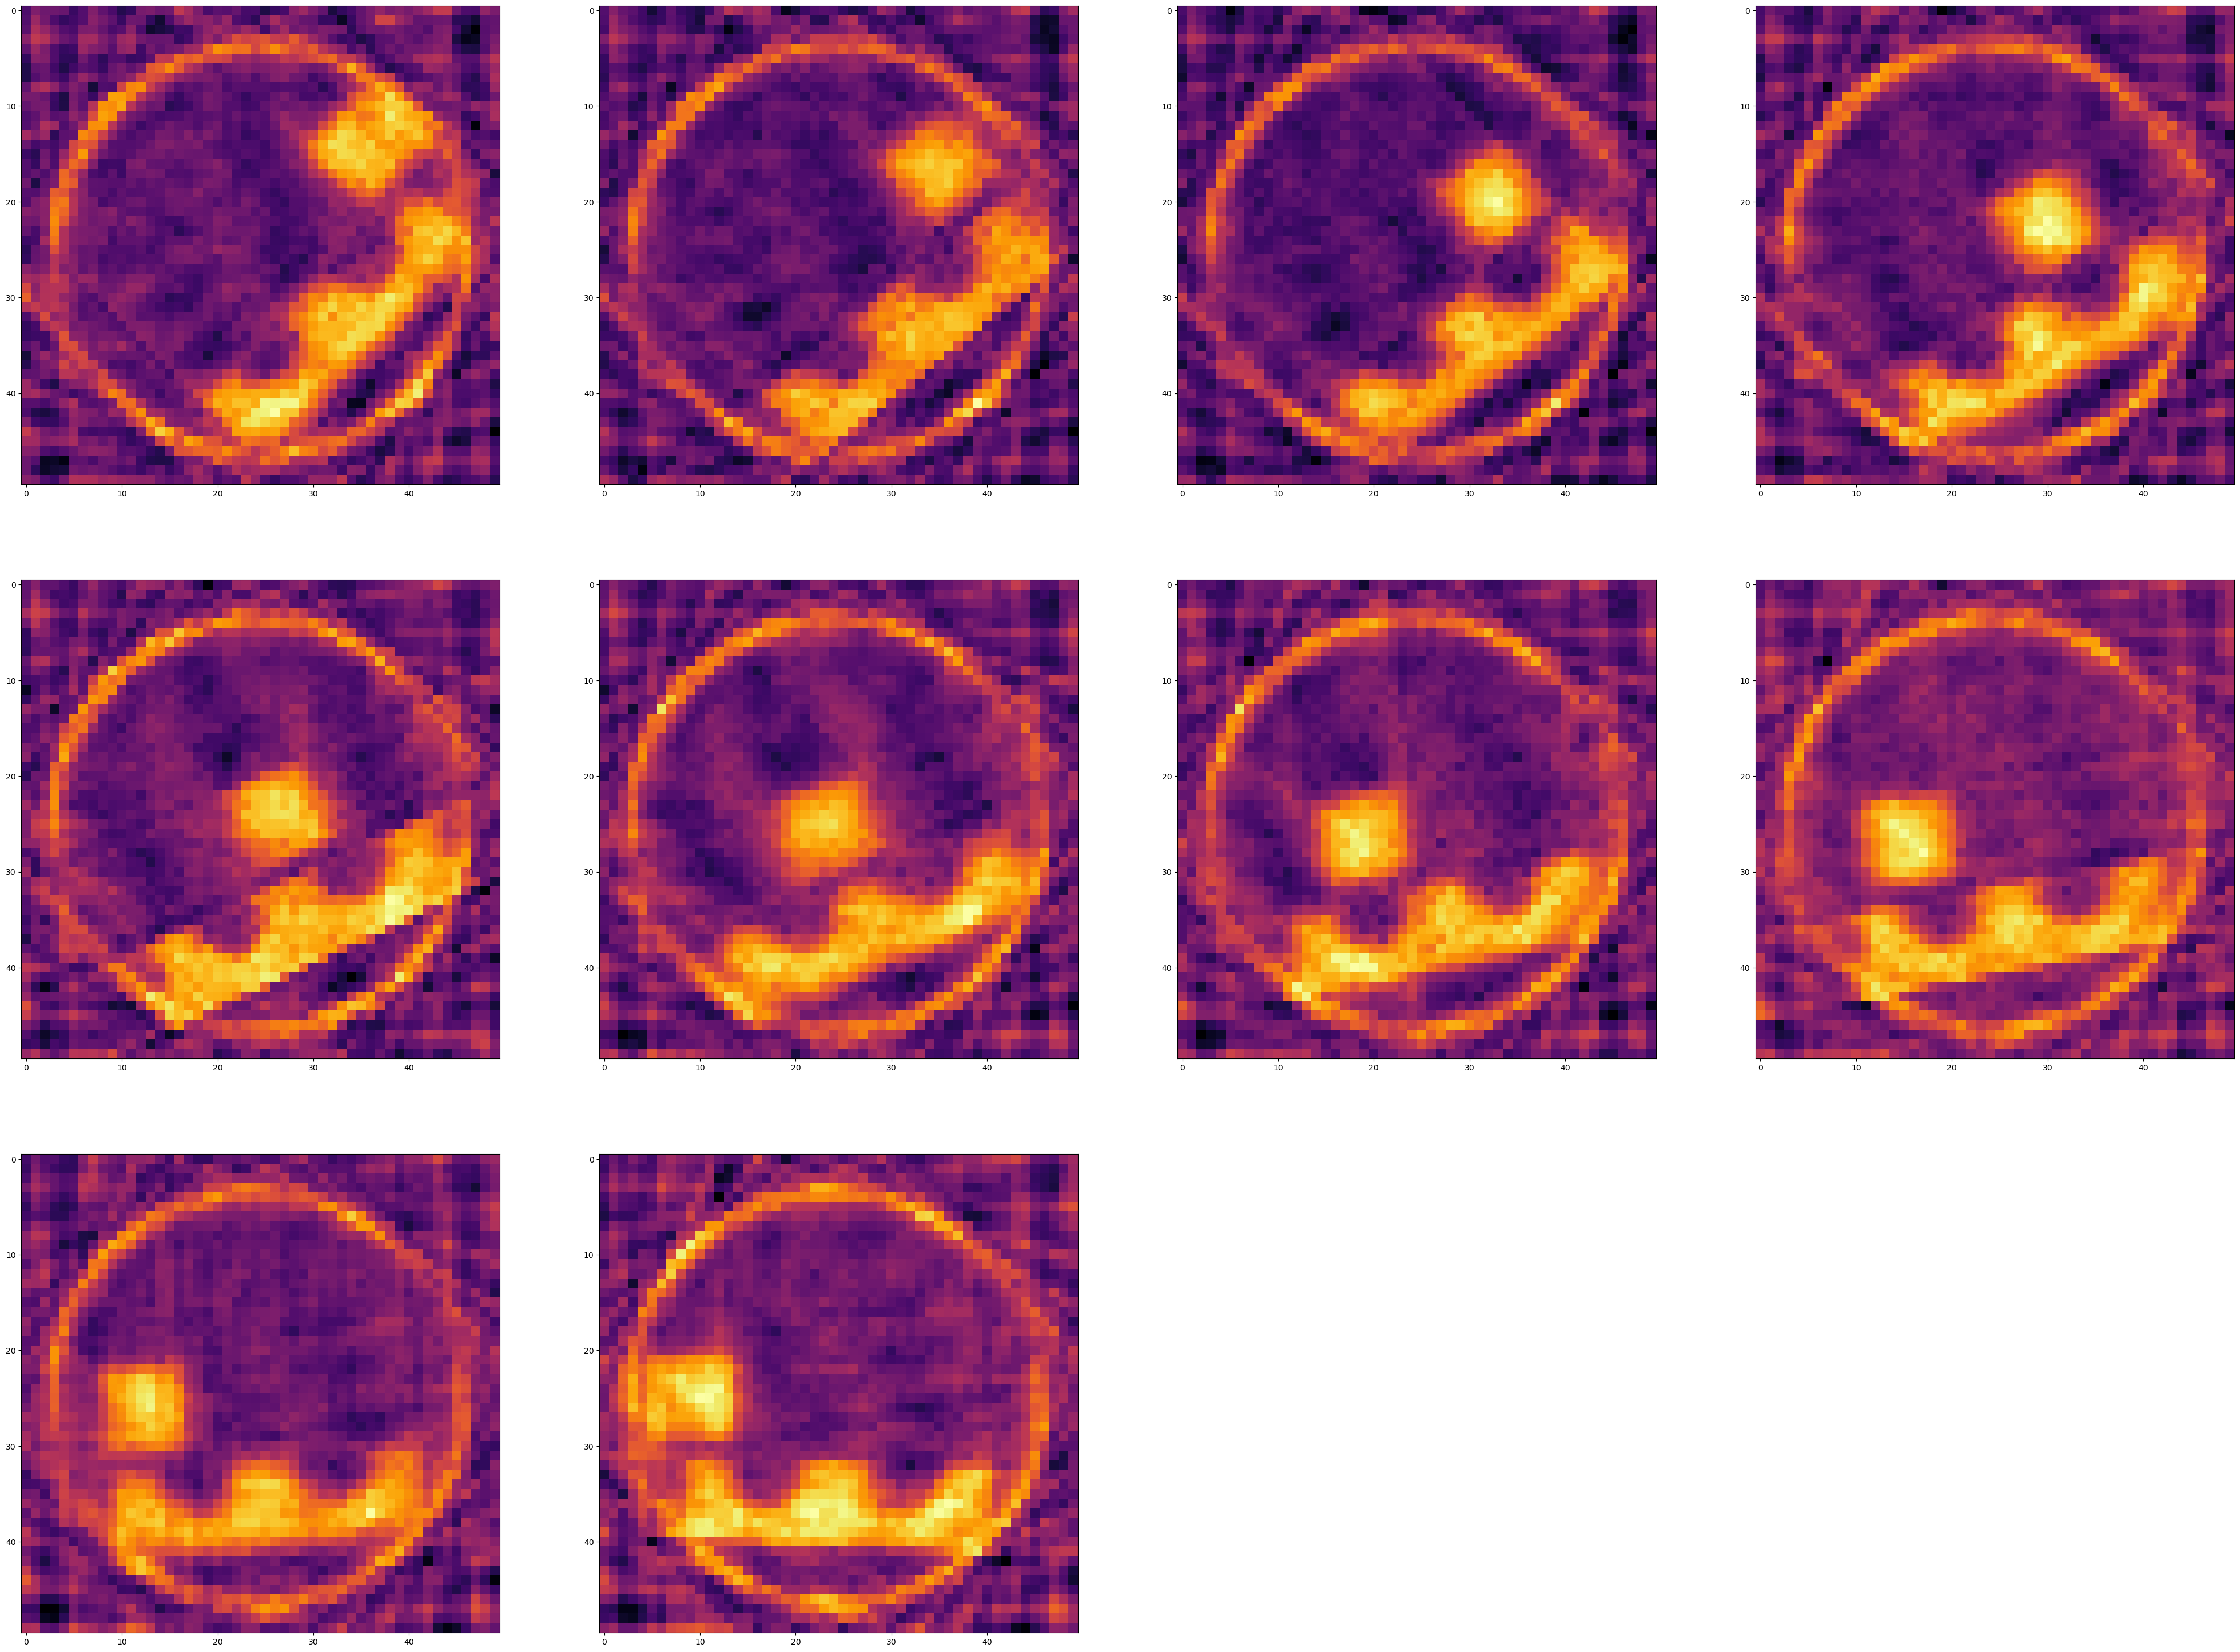

In [19]:
plot_recstructions_series(xx, (nx, ny, nt), dynamic = False, testproblem = 'STEMPO', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/STEMPO')

## With new "generate_stempo" function

In [22]:
(F, d, Aseq, B, nx, ny, nt, savedelta, truth) = generate_stempo1(data_set = 'simulation', data_thinning = 2,  views=11, new_shape= (50,50),columnsshift=14,noise_level = 0.01)

#### Access all the ground truth images (360 images of size 560 x 560)

In [23]:
f = spio.loadmat(f'./data/stempo_data/stempo_ground_truth_2d_b4.mat')

#### Access the ground truth images used for this experiment (see get_stempo_data on how they are choosen)

#### Step 2: Solve the static inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [41]:
timestep = 9
L = spatial_derivative_operator(nx, ny, 1)
b_vec = B[timestep].reshape((-1,1))
(x, info) = MMGKS(Aseq[timestep], b_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter = 10, regparam = 'gcv', x_true=None)


running MMGKS...: 100%|██████████| 10/10 [00:00<00:00, 21.82it/s]


(-0.5, 49.5, 49.5, -0.5)

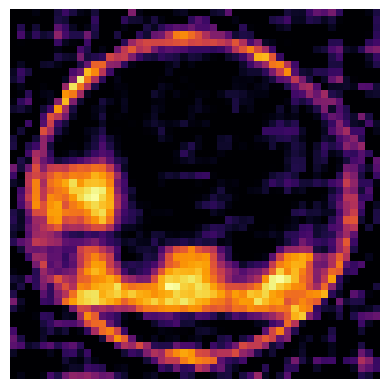

In [42]:
x[x<0] = 0
plt.imshow(x.reshape((nx, ny)))
plt.set_cmap('inferno')
plt.axis('off')

In [43]:
xx = list(range(nt))
L = spatial_derivative_operator(nx, ny, 1)
for i in range(nt):
    b_vec = B[i].reshape((-1,1))
    (x, info) = MMGKS(Aseq[i], b_vec, L, pnorm=2, qnorm=1, projection_dim=3, n_iter = 10, regparam = 'gcv', x_true=None)
    xx[i] = x

running MMGKS...: 100%|██████████| 10/10 [00:00<00:00, 21.20it/s]


<Figure size 640x480 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

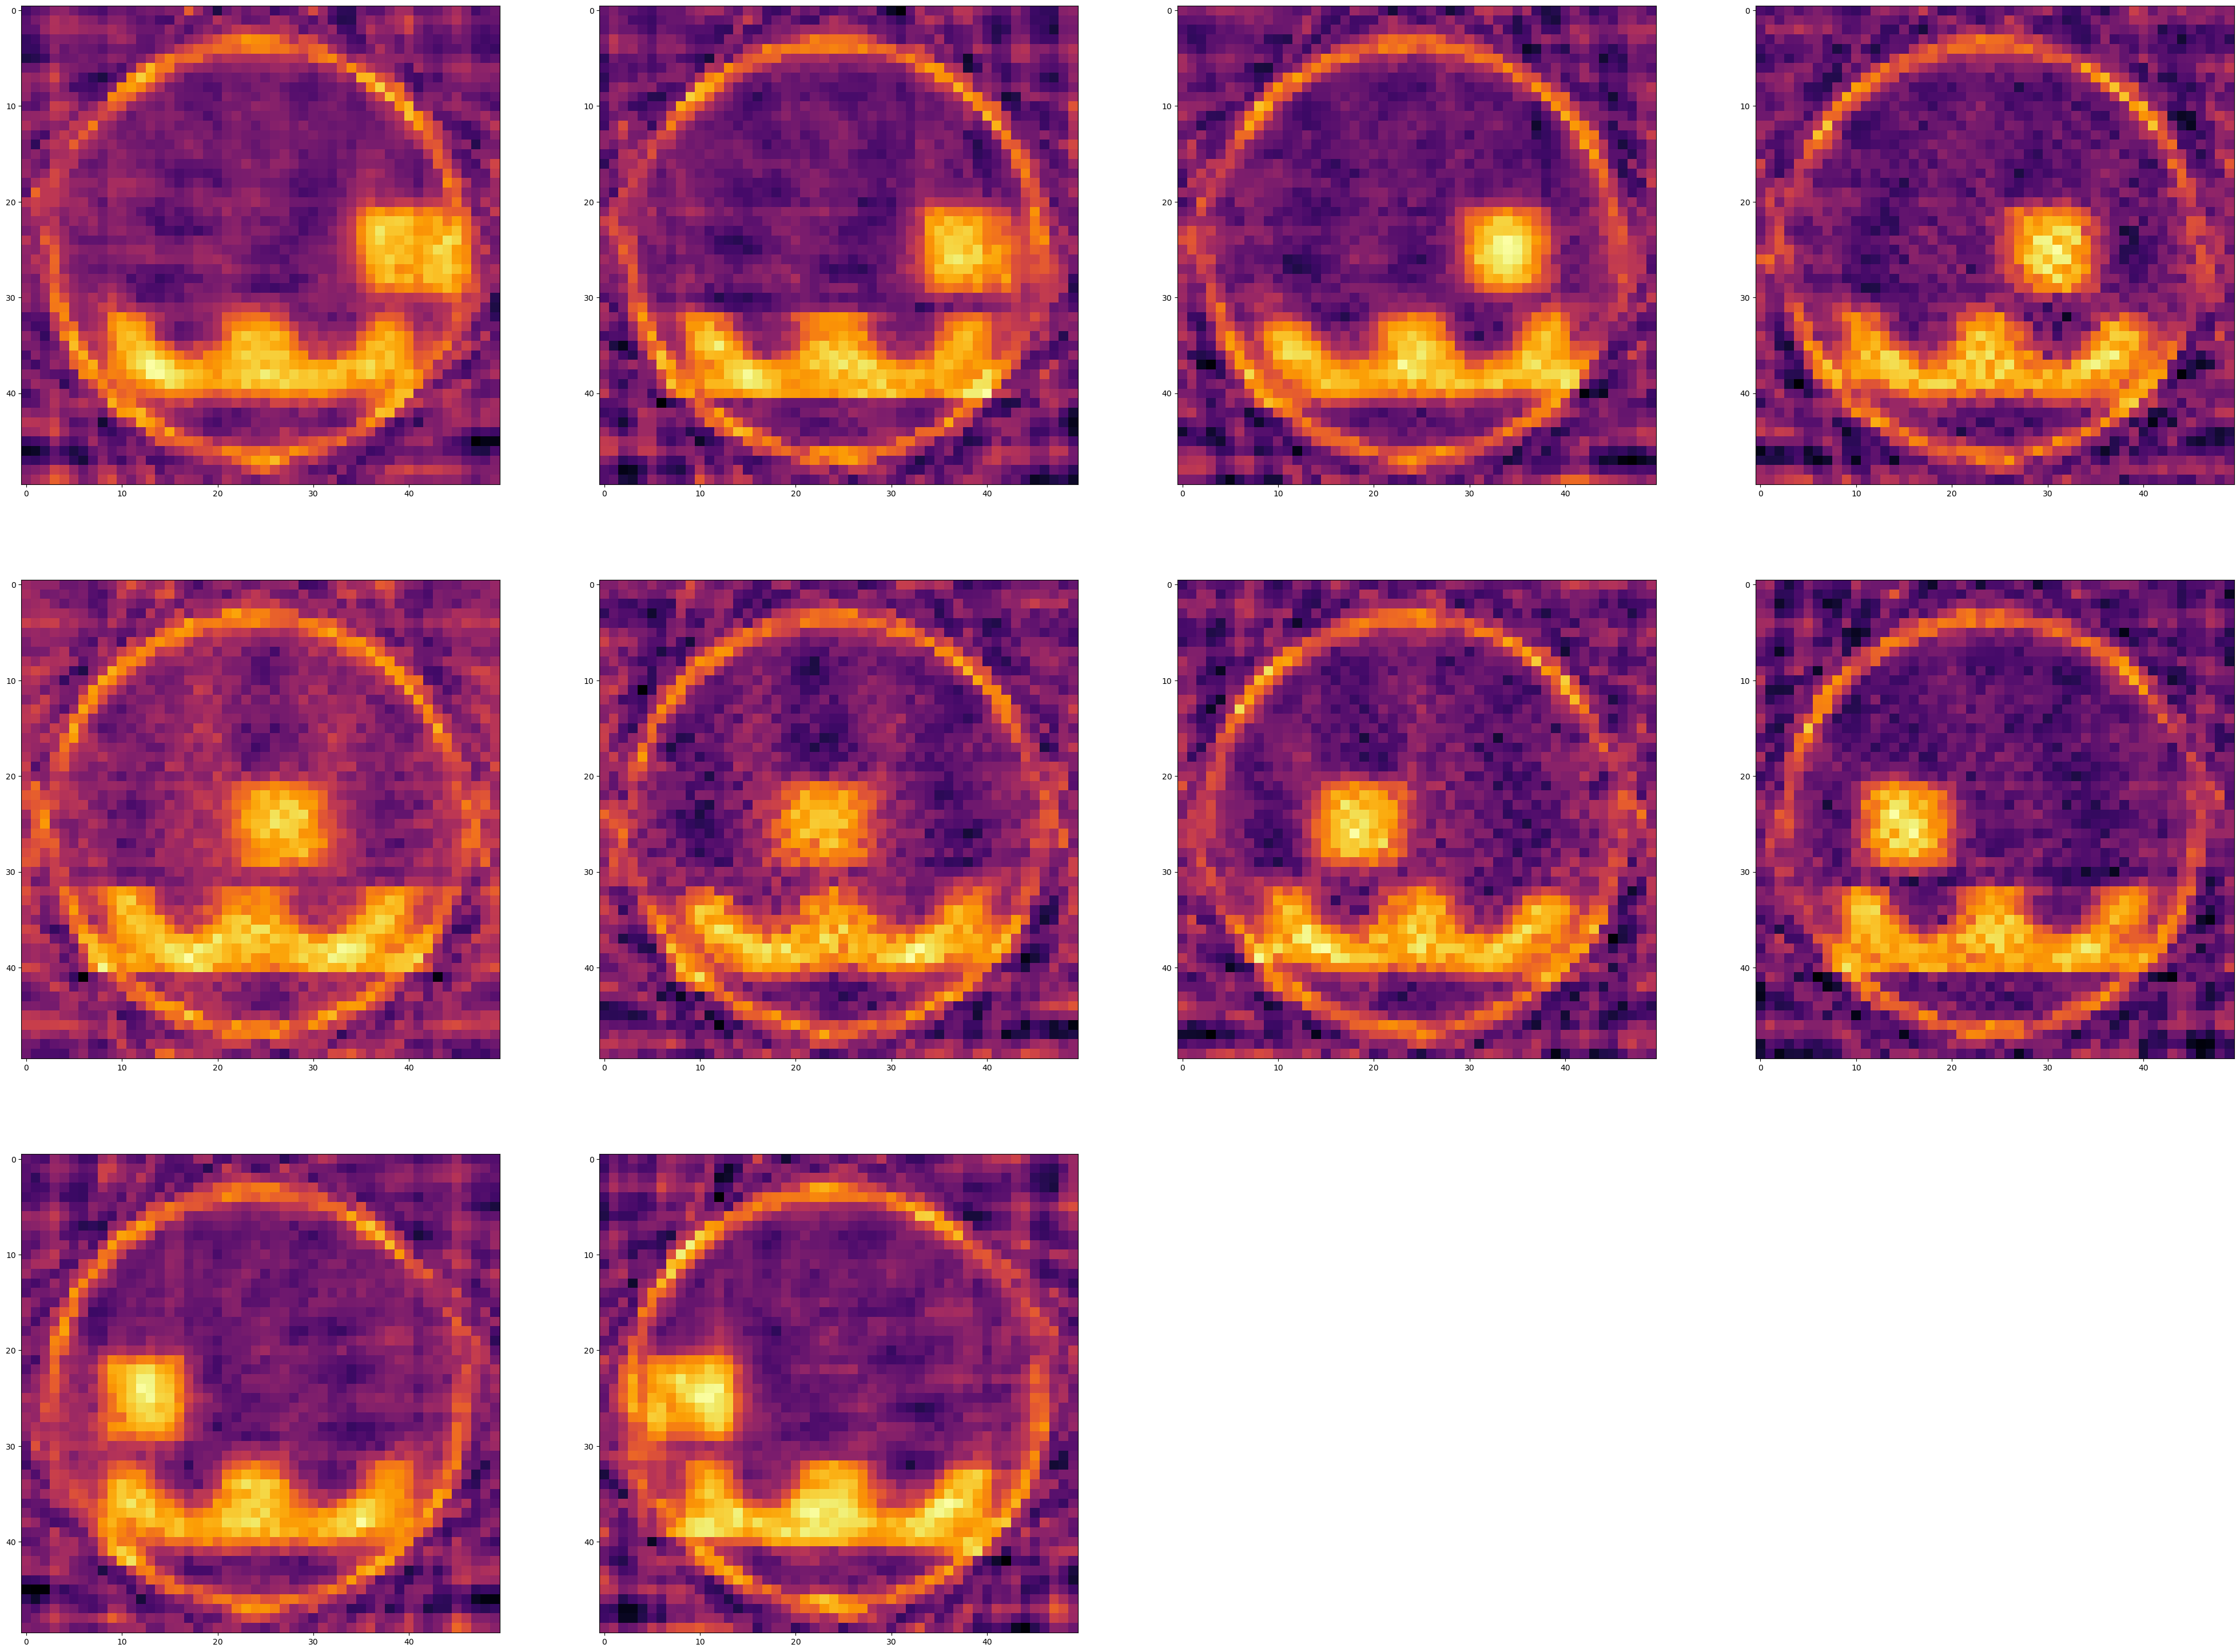

In [44]:
plot_recstructions_series(xx, (nx, ny, nt), dynamic = False, testproblem = 'STEMPO', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/STEMPO')